<img src="../img/hu-logo.png" align="right" width="120">

# Model generalization, validation and overfitting

This notebook continues the dataset studied in notebook `l08-2-nn-spiral.ipynb`. We focus on model validation and overfitting and learn about some important limitations of the neural network we implemented before.

We 
1. withold certain parts of the feature/target space from the model during training and
1. evaluate the model on this hold-out data

In [1]:
import io

import l08_lib
import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection
import torch
import torch.nn
import torch.nn.functional
import torch.optim
import torch.utils.data

In [2]:
plt.rcParams.update(
    {
        "figure.figsize": (9, 9),
        "axes.titlesize": 20,
        "axes.labelsize": 15,
        "legend.fontsize": 15,
        "axes.grid": True,
        "axes.axisbelow": True,
        "pcolor.shading": "auto",
    }
)

## Data

In [3]:
def generate_data(N=1_000, n_loops=2.5, noise=0.6, seed=501, debug=False):

    np.random.seed(seed)
    r = np.sqrt(np.random.rand(N)) * n_loops * (2 * np.pi)

    class0 = np.column_stack(
        [
            -np.cos(r) * r + np.random.rand(len(r)) * noise,
            np.sin(r) * r + np.random.rand(len(r)) * noise,
        ]
    )
    class1 = -class0
    X = np.vstack([class0, class1]).astype(np.float32)
    y = np.hstack([np.zeros(len(class0)), np.ones(len(class0))])
    r = np.tile(r, 2)

    index = np.arange(len(y))
    np.random.shuffle(index)
    X = X[index, :]
    y = y[index]
    r = r[index]

    if debug:
        return X, y, r
    else:
        return X, y

In [4]:
X, y, r = generate_data(N=3_000, n_loops=3, debug=True)

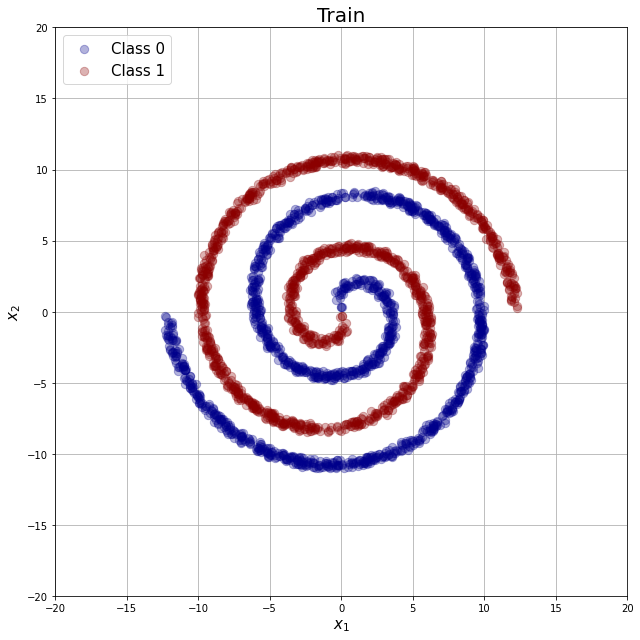

In [5]:
x_train = X[r <= 12.5, :]
y_train = y[r <= 12.5]

l08_lib.plot_spiral(x_train, y_train, xlim=(-20, 20), ylim=(-20, 20), title="Train")

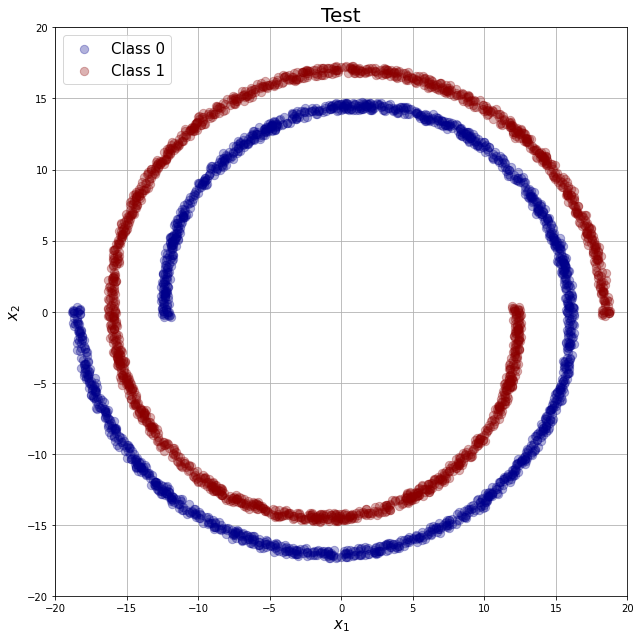

In [6]:
x_test = X[r > 12.5, :]
y_test = y[r > 12.5]

l08_lib.plot_spiral(x_test, y_test, xlim=(-20, 20), ylim=(-20, 20), title="Test")

In [7]:
x_train, x_valid, y_train, y_valid = sklearn.model_selection.train_test_split(
    x_train, y_train, test_size=0.20, random_state=501
)

## Test model on unseen parts of the feature/target space

### Config

In [8]:
config = {
    "trainer": {
        "epochs": 600,
    },
    "model": {
        "n_features": 2,
        "layers": [20, 15, 10, 5],
    },
    "data": {
        "train": {
            "batch_size": 512,
            "shuffle": True,
            "drop_last": True,
        },
        "valid": {
            "batch_size": x_valid.shape[0],
            "shuffle": False,
            "drop_last": False,
        },
    },
    "optimizer": {
        "lr": 0.01,
    },
}

### Data

In [9]:
xt_train, yt_train, xt_valid, yt_valid, xt_test, yt_test = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid, x_test, y_test)
)

In [10]:
ds_train = torch.utils.data.TensorDataset(xt_train, yt_train)
dl_train = torch.utils.data.DataLoader(ds_train, **config["data"]["train"])

### Trainer

In [11]:
class Trainer:
    def __init__(self, train, validation, model):
        self.train = train
        self.validation = validation
        self.model = model
        self.opt = torch.optim.Adam(self.model.parameters())

    def fit(self, n_epochs):
        for epoch in range(n_epochs):

            self.model.train()
            for xb, yb in self.train:
                self.opt.zero_grad()
                loss_train = torch.nn.functional.binary_cross_entropy_with_logits(
                    self.model(xb).flatten(), yb
                )
                loss_train.backward()
                self.opt.step()

            self.model.eval()
            with torch.no_grad():
                loss_valid = torch.nn.functional.binary_cross_entropy_with_logits(
                    self.model(self.validation[0]).flatten(), self.validation[1]
                )

    def predict(self, x):
        return torch.sigmoid(self.model(x))

## Training

In [12]:
torch.manual_seed(501)
np.random.seed(501)

In [13]:
model = l08_lib.Net(**config["model"])
trainer = Trainer(dl_train, [xt_valid, yt_valid], model)
trainer.fit(n_epochs=config["trainer"]["epochs"])

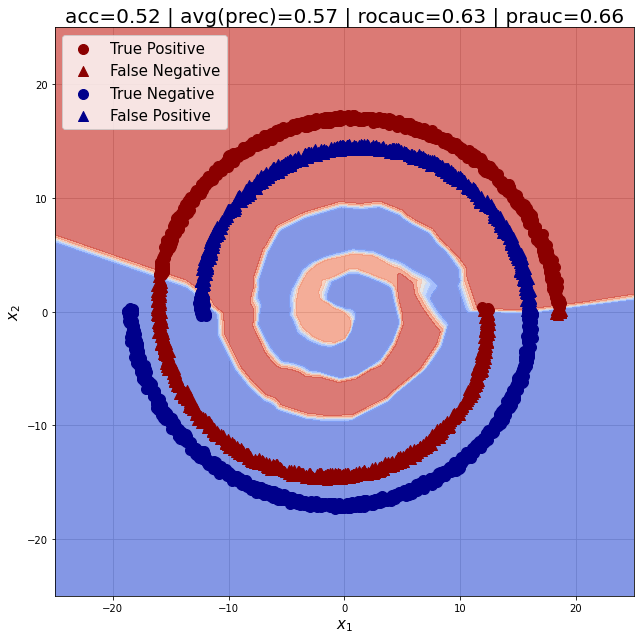

In [14]:
l08_lib.score(xt_test, y_test, trainer, xlim=(-25, 25), ylim=(-25, 25))

<br>
<br>
&mdash; <br>
Dr. Sebastian Gabel <br>
Machine Learning in Marketing &ndash; Lecture 8 <br>
2021